# Pneumonia Normal Chest X-ray Classification



In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Activation, ZeroPadding2D, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#building the neural net
model = Sequential()
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', input_shape=(64,64,1), activation='relu'))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.40))
model.add(Dense(2, activation='softmax'))

In [3]:
#variable for Image Generator to read from separate files 
gen = ImageDataGenerator()

In [4]:
#from files load shape, set color to grayscale, shuffle images for seed, batch size
train_batches = gen.flow_from_directory("chest_xray/pandn/train",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory("chest_xray/pandn/val", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=24)
test_batches = gen.flow_from_directory("chest_xray/pandn/test", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
len(valid_batches)

1

In [6]:
len(train_batches)

326

In [7]:
#compile the model
model.compile(Adam(lr=0.001),loss="categorical_crossentropy", metrics=["accuracy"])

In [8]:
import numpy as np

In [9]:
#class imbalance
COUNT_PNEUMONIA=3875
COUNT_NORMAL=1341
TRAIN_IMG_COUNT=COUNT_NORMAL+COUNT_PNEUMONIA
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias


array([1.06113006])

In [10]:
#create weights for class imbalance
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [11]:
#fit the model
hist=model.fit(train_batches,validation_data=valid_batches,epochs=30, steps_per_epoch=16, validation_steps=1, class_weight=class_weight)

Epoch 1/30
16/16 [==============================] - 4s 264ms/step - loss: 0.9779 - accuracy: 0.7969 - val_loss: 0.9279 - val_accuracy: 0.6250
Epoch 2/30
16/16 [==============================] - 4s 240ms/step - loss: 0.5430 - accuracy: 0.8320 - val_loss: 36.9367 - val_accuracy: 0.5000
Epoch 3/30
16/16 [==============================] - 4s 225ms/step - loss: 0.3979 - accuracy: 0.8477 - val_loss: 0.3587 - val_accuracy: 0.6875
Epoch 4/30
16/16 [==============================] - 4s 235ms/step - loss: 0.2767 - accuracy: 0.8828 - val_loss: 0.2961 - val_accuracy: 0.8750
Epoch 5/30
16/16 [==============================] - 4s 238ms/step - loss: 0.2726 - accuracy: 0.8789 - val_loss: 0.3117 - val_accuracy: 0.8125
Epoch 6/30
16/16 [==============================] - 4s 236ms/step - loss: 0.2043 - accuracy: 0.9062 - val_loss: 2.0665 - val_accuracy: 0.5625
Epoch 7/30
16/16 [==============================] - 4s 267ms/step - loss: 0.2037 - accuracy: 0.9141 - val_loss: 6.1012 - val_accuracy: 0.5000
Epoch

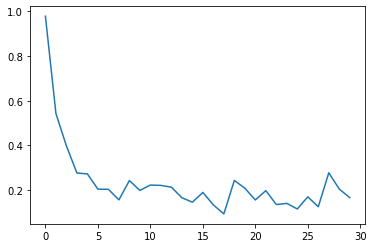

In [12]:
plt.plot(hist.history['loss'])

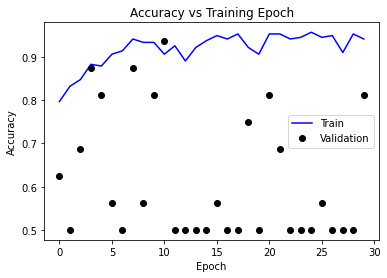

In [18]:
plt.plot(hist.history['accuracy'], 'b')
plt.plot(hist.history['val_accuracy'], 'ko')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

In [14]:
#predict on the model
no_steps = len(test_batches)
p = model.predict(test_batches, steps=no_steps, verbose=True)
pre = pd.DataFrame(p)

78/78 [==============================] - 5s 65ms/step


In [15]:
#class prediction results
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)

In [16]:
accuracy_score(pre["label"], pre["pre"])

0.8733974358974359

In [20]:
from sklearn.metrics import recall_score
recall_score(pre["label"], pre["pre"], average=None)

array([0.87179487, 0.87435897])

In [21]:
from sklearn.metrics import f1_score
f1_score(pre["label"], pre["pre"], average=None)

array([0.83778234, 0.89618922])

In [19]:
pre.head(60)

,0,1,filename,label,pre
0,0.996830,0.003170,NORMAL/IM-0001-0001.jpeg,0,0
1,0.925185,0.074815,NORMAL/IM-0003-0001.jpeg,0,0
2,0.906884,0.093116,NORMAL/IM-0005-0001.jpeg,0,0
3,0.618312,0.381688,NORMAL/IM-0006-0001.jpeg,0,0
4,0.990766,0.009234,NORMAL/IM-0007-0001.jpeg,0,0
5,0.962648,0.037352,NORMAL/IM-0009-0001.jpeg,0,0
6,0.994101,0.005899,NORMAL/IM-0010-0001.jpeg,0,0
7,0.963908,0.036092,NORMAL/IM-0011-0001-0001.jpeg,0,0
8,0.960096,0.039904,NORMAL/IM-0011-0001-0002.jpeg,0,0
9,0.975248,0.024752,NORMAL/IM-0011-0001.jpeg,0,0


In [22]:
pre.to_csv('PNresults.csv')

In [23]:
one=pre.loc[pre['label'] == 0]

one['pre'].value_counts()

0    204
1     30
Name: pre, dtype: int64

In [24]:
one=pre.loc[pre['label'] == 1]

one['pre'].value_counts()

1    341
0     49
Name: pre, dtype: int64